In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data = pd.read_csv("drive/MyDrive/Colab Notebooks/data.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [ ]:
print('lenght of data is', len(data))

lenght of data is 1599999


In [ ]:
data.shape

(1599999, 6)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

In [ ]:
np.sum(data.isnull().any(axis=1))

0

In [ ]:
data = data[['text','label']]
data['label'][data['label'] == 4] = 1
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]
data = pd.concat([data_pos, data_neg])
data['text'] = data['text'].str.lower()
data['text'].tail()

19995                            one more day of holidays 
19996    feeling so down right now .. i hate you damn h...
19997    geez,i hv to read the whole book of personalit...
19998    i threw my sign at donnie and he bent over to ...
19999    @heather2711 good thing i didn't find any then...
Name: text, dtype: object

In [ ]:
STOPWORDS = set(stopwords.words('english'))

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [ ]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998     threw sign donnie bent get thingee made sad face
19999    heather2711 good thing find none ones like com...
Name: text, dtype: object

In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [ ]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

data['text'] = data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [ ]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [ ]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather god thing find none ones like come siz...
Name: text, dtype: object

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [ ]:
st = nltk.PorterStemmer()

def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [ ]:
lm = nltk.WordNetLemmatizer()

def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [ ]:
X = data.text
y = data.label

max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
sequences_matrix.shape

(40000, 500)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [ ]:
def tensorflow_based_model(): 
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(2000, 50, input_length=max_len)(inputs) 
    layer = LSTM(64)(layer) 
    layer = Dense(256, name='FC1')(layer) 
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer) 
    layer = Dense(1, name='out_layer')(layer) 
    layer = Activation('sigmoid')(layer) 
    model = Model(inputs=inputs, outputs=layer) 
    return model

In [ ]:
model = tensorflow_based_model()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, batch_size=80, epochs=6, validation_split=0.1)
print('Training finished !!')

Epoch 1/6
315/315 [==============================] - 183s 569ms/step - loss: 0.6107 - accuracy: 0.6548 - val_loss: 0.5277 - val_accuracy: 0.7371
Epoch 2/6
315/315 [==============================] - 149s 473ms/step - loss: 0.5123 - accuracy: 0.7512 - val_loss: 0.5176 - val_accuracy: 0.7436
Epoch 3/6
315/315 [==============================] - 154s 489ms/step - loss: 0.5159 - accuracy: 0.7536 - val_loss: 0.5134 - val_accuracy: 0.7454
Epoch 4/6
315/315 [==============================] - 158s 503ms/step - loss: 0.4937 - accuracy: 0.7637 - val_loss: 0.5163 - val_accuracy: 0.7439
Epoch 5/6
315/315 [==============================] - 146s 463ms/step - loss: 0.4814 - accuracy: 0.7725 - val_loss: 0.5206 - val_accuracy: 0.7400
Epoch 6/6
315/315 [==============================] - 142s 452ms/step - loss: 0.4699 - accuracy: 0.7757 - val_loss: 0.5294 - val_accuracy: 0.7443
Training finished !!


In [ ]:
accr1 = model.evaluate(X_test, Y_test)
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

375/375 [==============================] - 32s 84ms/step - loss: 0.5244 - accuracy: 0.7439
Test set
  Accuracy: 0.74
375/375 [==============================] - 29s 77ms/step




confusion matrix


[[4319 1690]
 [1383 4608]]




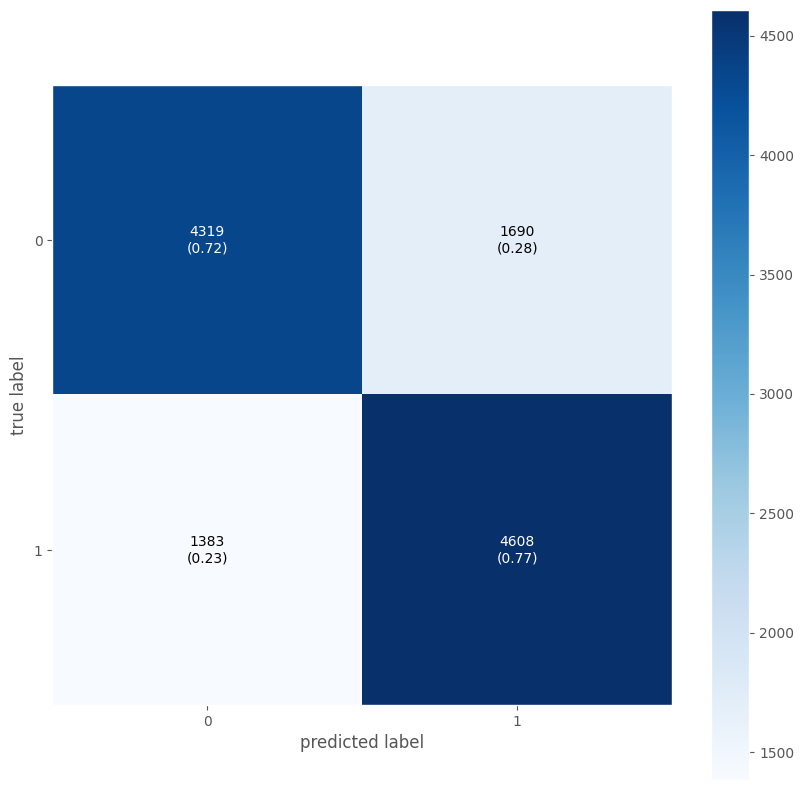

In [ ]:
print('\n')
print("confusion matrix")
print('\n')
CR = confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

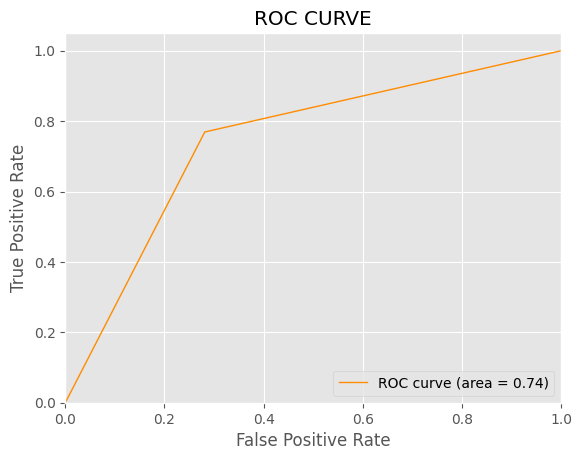

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()